## Open notebook in: 
| Colab                                 | Kaggle                                        | Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH02/chapter_02_code_examples.ipynb)                       | [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com//Nicolepcx/Transformers-in-Action/blob/main/CH02/chapter_02_code_examples.ipynb)                       | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH02/chapter_02_code_examples.ipynb)|             

# About this Notebook

This jupyter notebook is the accompanying notebook for chapter 2 of the book "Transformers in Action". Where we look more closely at the Transformer architecture: 

![Transformer architecture](https://drive.google.com/uc?id=1-PKs-MiqCc59EIObZ6BwMh73NvyqH2cq)

The notebook provides code for: 

- Gradient-comparison of an RNN and Transformer model
- A simplified encoder layer
- Future masking example
- Softmax scaling example
- A simple position-wise feed-forward network
- Positional encoding implementation and plotting function
- Additive and multiplicative attention implementation and plotting function
- Self-attention implementation and plotting function 
- Function to plot the computational graphs of an LSTM and Transformer model


# imports

In [1]:
# Uncomment to install library
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
from graphviz import Digraph
import torch.optim as optim
import torchtext
import spacy
from matplotlib.colors import ListedColormap


# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

## Gradient-comparison of an RNN and Transformer model

This code defines two models: a simple RNN model with a single LSTM layer and a self-attention model. It then creates a sentence and converts it to a tensor of word embeddings using pre-trained GloVe embeddings. The RNN and self-attention models are then applied to this tensor, and the gradients of the input sequence are computed for both models.

The code demonstrates how the gradients for the RNN model and self-attention model differ. The gradients for the RNN model are computed by summing the gradients of each word in the input sequence, while the gradients for the self-attention model are computed directly from the attention weights. This illustrates how the self-attention mechanism in the Transformer architecture can help to mitigate the vanishing gradient problem in RNNs.

In [3]:
# Load a pre-trained word embedding model
glove_vectors = torchtext.vocab.GloVe(name='6B', dim=100)

# Define a simple RNN model with a single LSTM layer
class SimpleRNN(nn.Module):
    """
    A simple RNN model with a single LSTM layer.

    Args:
        input_size (int): The size of the input.
        hidden_size (int): The size of the hidden layer.
        num_layers (int): The number of layers in the LSTM.

    Attributes:
        rnn (nn.LSTM): The LSTM layer.
        fc (nn.Linear): The fully connected output layer.

    Methods:
        forward(x): Forward pass of the model.

    Returns:
        torch.Tensor: Output tensor of the model.

    """
    def __init__(self, input_size, hidden_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(1), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(1), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))  # Output of shape (seq_len, batch_size, hidden_size)
        out = out[-1, :, :]  # Take the last hidden state as the output
        out = self.fc(out)
        return out

# Define a self-attention model
class SelfAttention(nn.Module):
    """
    Self-attention model.

    Args:
        input_size (int): The size of the input.
        hidden_size (int): The size of the hidden layer.

    Attributes:
        query (nn.Linear): The query linear layer.
        key (nn.Linear): The key linear layer.
        value (nn.Linear): The value linear layer.
        softmax (nn.Softmax): The softmax activation function.

    Methods:
        forward(x): Forward pass of the model.

    Returns:
        torch.Tensor: Output tensor of the model.

    """
    def __init__(self, input_size, hidden_size):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_size, hidden_size)
        self.key = nn.Linear(input_size, hidden_size)
        self.value = nn.Linear(input_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        Q = self.query(x)  # Query tensor of shape (seq_len, hidden_size)
        K = self.key(x)  # Key tensor of shape (seq_len, hidden_size)
        V = self.value(x)  # Value tensor of shape (seq_len, hidden_size)
        attention_weights = self.softmax(torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(K.size(-1), dtype=torch.float)))  # Attention weights of shape (seq_len, seq_len)
        out = torch.matmul(attention_weights, V)  # Output of shape (seq_len, hidden_size)
        return out




In [4]:
# Define a simple sentence
nlp = spacy.load('en_core_web_sm')
sentence = nlp("The quick brown fox jumps over the lazy dog and runs through the fields, the lazy dog barks loudly and then chases the quick brown fox through the forest")

# Convert the sentence to a tensor of word embeddings
x = torch.stack([glove_vectors[word.text.lower()].to(torch.float) for word in sentence], dim=0)
x.requires_grad = True

# Create an instance of the RNN model and compute the output
rnn_model = SimpleRNN(input_size=glove_vectors.dim, hidden_size=16, num_layers=1)
rnn_optimizer = optim.SGD(rnn_model.parameters(), lr=0.1)
rnn_criterion = nn.MSELoss()
rnn_output = rnn_model(x.unsqueeze(1))

# Compute the loss and gradients for the RNN model
rnn_target = torch.tensor([1.0])
rnn_loss = rnn_criterion(rnn_output, rnn_target)
rnn_loss.backward(retain_graph=True)

# Print the gradients of the input sequence for the RNN model
print("Gradients for RNN model:")
rnn_grad = x.grad
rnn_grad_sum = rnn_grad.sum(dim=1)
print(rnn_grad_sum)

# Reset gradients to zero before computing gradients for self-attention model
x.grad.zero_()

# Create an instance of the self-attention model and compute the output
attention_model = SelfAttention(input_size=glove_vectors.dim, hidden_size=16)
attention_optimizer = optim.SGD(attention_model.parameters(), lr=0.1)
attention_criterion = nn.MSELoss()
attention_output = attention_model(x)

# Compute the loss and gradients for the self-attention model
attention_target = torch.tensor([1.0])
attention_loss = attention_criterion(attention_output[-1, :], attention_target)
attention_loss.backward(retain_graph=True)

# Print the gradients of the input sequence for the self-attention model
print("\nGradients for self-attention model:")
attention_grad = x.grad
attention_grad_sum = attention_grad.sum(dim=1)
print(attention_grad_sum)


Gradients for RNN model:
tensor([ 1.8642e-06,  2.9300e-06,  2.2280e-06,  3.5569e-06,  9.8836e-06,
         1.0310e-05,  9.9921e-06,  2.2174e-05,  2.6846e-05,  2.6116e-05,
         8.7927e-05,  8.5729e-05,  1.3431e-04,  1.8049e-04,  2.2535e-04,
         1.7213e-04,  4.8340e-04,  7.1175e-04,  9.9857e-04,  1.6600e-03,
         2.1433e-03,  3.7129e-03,  4.0189e-03,  5.7624e-03,  1.7868e-02,
         6.9307e-03,  3.2868e-02,  1.0413e-01,  3.0542e-01, -1.1142e-02])

Gradients for self-attention model:
tensor([-0.0035, -0.0042, -0.0024, -0.0028, -0.0044, -0.0039, -0.0035, -0.0033,
        -0.0038, -0.0037, -0.0034, -0.0040, -0.0035, -0.0037, -0.0038, -0.0035,
        -0.0033, -0.0038, -0.0034, -0.0029, -0.0037, -0.0038, -0.0037, -0.0035,
        -0.0042, -0.0024, -0.0028, -0.0040, -0.0035,  0.0049])


## Encoder Layer


![Encoder](https://drive.google.com/uc?id=1imI0se1JFWDDGTD1aQ0bNzHAH--21Uy0)


The `EncoderLayer` class represents a single layer in the Transformer encoder architecture. It consists of two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feedforward network. The self-attention mechanism attends to all positions in the input sequence and computes a weighted sum of the values at each position, where the weights are determined by a dot product between the query and key vectors. The feedforward network consists of two linear transformations with a Gated Linear Unit (GLU) activation function in between. The layer also includes two residual connections and layer normalization for each sub-layer, as well as dropout regularization. The `EncoderLayer` class takes as input the number of features in the input, the number of attention heads, the dimension of the feedforward network, and an optional dropout probability.






In [5]:
class EncoderLayer(nn.Module):
    """
    A single encoder layer in the Transformer architecture.

    Args:
    d_model (int): The number of expected features in the input.
    nhead (int): The number of attention heads.
    dim_feedforward (int): The dimension of the feedforward network model.
    dropout (float, optional): The dropout probability applied to the output. Default: 0.1.

    Attributes:
    self_attn (nn.MultiheadAttention): The self-attention layer.
    feed_forward (nn.Sequential): The feedforward network model.
    norm1 (LayerNorm): The first normalization layer.
    norm2 (LayerNorm): The second normalization layer.
    dropout1 (nn.Dropout): The first dropout layer.
    dropout2 (nn.Dropout): The second dropout layer.

    Methods:
    forward(x, mask=None): Forward pass of the encoder layer.

    Returns:
    torch.Tensor: Output tensor of the encoder layer.

    Examples:
    >>> encoder_layer = EncoderLayer(512, 8, 2048, 0.1)
    >>> x = torch.randn(32, 100, 512)
    >>> output = encoder_layer(x)
    """
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)        
        self.feed_forward = nn.Sequential( 
            nn.Linear(d_model, 2 * dim_feedforward),
            GLU(input_size=dim_feedforward, output_size=d_model),
            nn.Dropout(dropout)
            )
        self.norm1 = LayerNorm(d_model) 
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout) 
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Forward pass of the encoder layer.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, seq_len, d_model).
            mask (torch.Tensor, optional): The mask tensor of shape (seq_len, seq_len). Default: None.

        Returns:
            torch.Tensor: Output tensor of the encoder layer.

        """
        # self-attention layer 
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # feed-forward layer  
        ff_output = self.feed_forward(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

## Future-Masking

The following code defines a function called plot_mask that takes an integer n as input and generates a plot of future masking for a sequence of length n. Remember, future masking is a technique used in the Transformer architecture to prevent each position in the output sequence from attending to positions after itself during the self-attention step. The function uses numpy to create a lower triangular matrix of ones and zeros, where the ones correspond to the positions that should be masked to demonstrate this behavior. 

Mathematical representation of future masking:

Given a sequence of tokens $X = [x_1, x_2, ..., x_n]$, we want to apply a mask $M$ such that:

$$M_{i,j} = \begin{cases}0 & \text{if } j \geq i \ -\infty & \text{otherwise} \end{cases}$$

where $M$ is an $n \times n$ matrix.

In other words, the mask sets all values in the upper triangle (including the diagonal) to $-\infty$, preventing the model from attending to any tokens beyond the current position during self-attention. This ensures that the model cannot cheat by attending to future information during training. The idea of future masking was introduced in the paper ["Attention Is All You Need" by Vaswani et al.](http://arxiv.org/abs/1706.03762).

In [6]:
def plot_mask(n, save_path=None):
    """
    Plots a binary mask for future masking in sequence-to-sequence models.

    Args:
        n (int): The size of the mask to plot.
        save_path (str): The file path to save the plot as a PNG image. If None, 
        the plot is not saved.

    Returns:
        None
    """
    mask = np.tril(np.ones((n, n)), k=0)
    cmap = ListedColormap(['#c0c0c0','#ffffff'])
    plt.figure(figsize=(6,6))
    plt.imshow(mask, cmap=cmap)
    plt.xlabel('Sequence position', fontsize=18)
    plt.ylabel('Sequence position',fontsize=18)
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

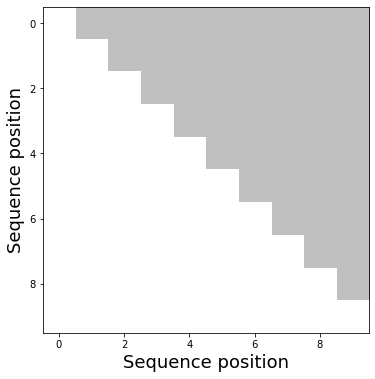

In [7]:
plot_mask(10, 'CH02_mask_example.png')

## Scaling example

This function plots the effect of scaling on softmax probabilities for a range of dot product values. The function computes softmax probabilities without scaling and with scaling, where the scaling factor is the square root of the dimension of the dot product matrix. The function then computes the variances of the dot product values and plots the results. The scaling factor is:

$$\frac{1}{\sqrt{d_k}}$$

were $d_k$ refers to the dimension of the key vectors. The scaling factor used in the Transformer architecture is the square root of the dimension of the feature space (e.g., 512 for a 512-dimensional feature space), which has been found to perform well in practice.
The idea of scaled dot attention was introduced in the paper ["Attention Is All You Need" by Vaswani et al.](http://arxiv.org/abs/1706.03762).

In [8]:
def plot_softmax_scaling():
    """
    This function generates a plot that illustrates the effect of scaling on 
    softmax probabilities. It computes the softmax probabilities for a range of 
    dot product values, with and without scaling, and plots the results. The plot
    also shows the variances of the dot product values for both cases.
    Returns: None
    
    """
    # Define a range of values for the dot product matrix
    x = np.linspace(-5, 5, 1000)

    # Compute the softmax probabilities without scaling
    y1 = np.exp(x) / np.sum(np.exp(x))

    # Compute the softmax probabilities with scaling
    y2 = np.exp(x / np.sqrt(512)) / np.sum(np.exp(x / np.sqrt(512)))

    # Compute the variances of the dot product values
    var1 = np.var(x)
    var2 = np.var(x / np.sqrt(512))

    # Plot the results
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y1, label='Unscaled', c="lightgrey")
    ax.plot(x, y2, label='Scaled', c="#58A3B3")
    ax.set_xlabel('Dot product values',fontsize=12)
    ax.set_ylabel('Softmax probabilities',fontsize=12)
    ax.set_title('Effect of scaling softmax probabilities', fontsize=14)
    ax.annotate(f'Variance (Unscaled) = {var1:.3f}', xy=(0.5, 0.008), xytext=(0.5, 0.0085),
                fontsize=12)
    ax.annotate(f'Variance (Scaled) = {var2:.3f}', xy=(-2.5, 0.0014), xytext=(-2.5, 0.0014),
                fontsize=12)
    ax.legend()
    # Save the figure as a PNG image
    plt.savefig('CH02_softmax_scaling.png', dpi=300, bbox_inches='tight')



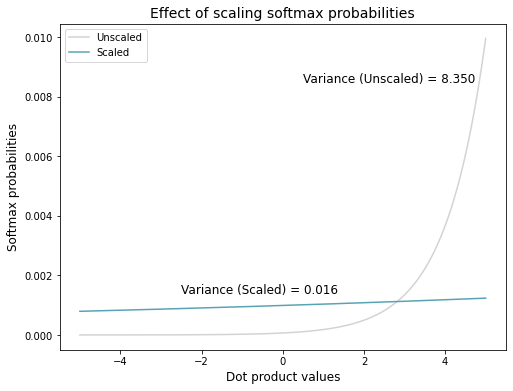

In [9]:
plot_softmax_scaling()

## Position-wise feed-foward networks

In this implementation, PositionwiseFeedforward is a class that inherits from nn.Module. The __init__ function initializes the input and hidden dimensions of the network, as well as a dropout rate. The forward function takes an input tensor x and passes it through two fully connected layers with ReLU activation, followed by a dropout layer. The output of the second fully connected layer is returned as the final output of the network.

To use this network, you can simply create an instance of PositionwiseFeedforward with the desired input and hidden dimensions, and call the forward method with your input tensor.

The mathematical formula for position-wise feedforward networks is:

$$ FFN(x) = max(0, xW_1 + b_1)W_2 + b_2 $$

where $x$ is the input tensor of shape (batch_size, seq_len, embedding_dim), $W_1$ is the weight matrix of the first linear layer of shape (embedding_dim, ff_hidden_dim), $b_1$ is the bias term of the first linear layer of shape (ff_hidden_dim,), $W_2$ is the weight matrix of the second linear layer of shape (ff_hidden_dim, embedding_dim), and $b_2$ is the bias term of the second linear layer of shape (embedding_dim,).

This formula computes a position-wise feedforward transformation on the input tensor $x$, where each element in the sequence is transformed independently of the others. The input tensor is first transformed by a linear layer with weight matrix $W_1$ and bias term $b_1$, followed by the application of the ReLU activation function. The result is then transformed again by another linear layer with weight matrix $W_2$ and bias term $b_2$. Finally, the output is returned as the transformed tensor.

In [10]:
class PositionwiseFeedforward(nn.Module):

    """
    Position-wise feedforward network used in the Transformer architecture.

    Args:
    input_dim (int): The input dimension of the network.
    hidden_dim (int): The hidden dimension of the network.
    dropout (float, optional): The dropout probability applied to the network. Default: 0.1.

    Attributes:
    input_dim (int): The input dimension of the network.
    hidden_dim (int): The hidden dimension of the network.
    dropout (nn.Dropout): A dropout layer applied to the network.
    fc1 (nn.Linear): The first fully connected layer of the network.
    fc2 (nn.Linear): The second fully connected layer of the network.

    Methods:
    forward(x): Forward pass of the network.

    Returns:
    torch.Tensor: Output tensor of the network.

    Examples:
    >>> feedforward = PositionwiseFeedforward(512, 2048, 0.1)
    >>> x = torch.randn(32, 100, 512)
    >>> output = feedforward(x)
    """

    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super(PositionwiseFeedforward, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


## Positional encoding

The following code defines a module for positional encoding, which is an important component of the Transformer architecture used in natural language processing tasks. The purpose of positional encoding is to inject positional information into the input embeddings of the model, which allows the model to differentiate between words that have the same embedding but appear in different positions in the sequence.

The PositionalEncoding module takes in the number of hidden units (`num_hiddens`) and the maximum sequence length (`max_len`) as arguments. It creates a positional embedding matrix using a mathematical formula that uses sinusoidal functions to encode position information. The resulting positional embedding tensor (`pe`) is then registered as a buffer in the module.

During the forward pass, the module takes in an input tensor $X$, which is the sequence of word embeddings. It adds the positional embedding tensor `pe` to the input tensor $X$, broadcasting the positional embedding tensor along the sequence length dimension. The resulting tensor contains both word embeddings and positional embeddings.

Finally, the `plot_embeddings` function can be used to visualize an example of the positional encoding. It takes in the positional encoding tensor `P` and plots the embeddings of several dimensions against the sequence position. This can help to see how the positional encoding varies across the sequence. The formula for computing the positional encoding is as follows:

$$
\begin{aligned}
P E_{(p o s, 2 i)} & =\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
P E_{(p o s, 2 i+1)} & =\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)
\end{aligned}
$$

The idea of positional encoding was introduced in the paper ["Attention Is All You Need" by Vaswani et al.](http://arxiv.org/abs/1706.03762)

In [11]:
class PositionalEncoding(nn.Module):  
    """
    Positional encoding module for transformer architecture.

    Args:
        num_hiddens (int): Number of hidden units.
        max_len (int): Maximum sequence length.

    Attributes:
        dropout (nn.Dropout): Dropout layer.
        pe (torch.Tensor): Positional encoding tensor.

    """
    def __init__(self, num_hiddens, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        # Create a positional embedding matrix
        position = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        div_term = torch.exp(torch.arange(0, num_hiddens, 2, dtype=torch.float32) * 
                             -(math.log(10000.0) / num_hiddens))
        pe = torch.zeros((1, max_len, num_hiddens))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, X):
        """
        Forward pass of positional encoding.

        Args:
            X (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Encoded tensor with positional information.

        """
        X = X + self.pe[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


def plot_embeddings(P):
    """
    Function to plot example positional encoding.

    Args:
        P (torch.Tensor): Positional encoding tensor.

    """
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, shape in zip(range(6, 10), ['-', '--', '-.', ':']):
        ax.plot(P[0, :, i], label=f"Dimension {i}", linestyle=shape)
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Embedding")
    plt.title("Example positional encoding")
    ax.legend()
    plt.savefig('CH02_positional_encoding.png', dpi=300, bbox_inches='tight')


You can modify the parameters `encoding_dim` and `num_steps` in the following code to see how the positional encoding matrix changes. `encoding_dim` determines the dimension of each embedding and `num_steps` determines the length of the sequence to be encoded. Once you modify these parameters and run the code, the resulting positional encodings get plotted using the `plot_embeddings` function.
Here we do the following:
<br><br>

1. Defining the dimensions of the positional encoding (encoding_dim) and the length of the sequence (num_steps).
2. Creating a PositionalEncoding object with the specified dimensions and sequence length.
3. Generating an input tensor of zeros with shape (1, num_steps, encoding_dim).
4. Passing the input tensor through the pos_encoding layer to obtain a tensor with positional information.
5. Extracting the positional encoding matrix pe from the pos_encoding object and slice it to include only the embeddings for the same sequence length as the input tensor.
6. Plotting the embeddings for dimensions 6 to 9 using the plot_embeddings function.

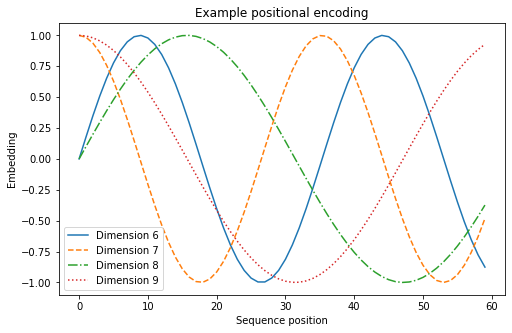

In [12]:
# Define the dimensions of the positional encoding and the length of the sequence
encoding_dim, num_steps = 32, 60

# Create a positional encoding object
pos_encoding = PositionalEncoding(encoding_dim, num_steps)

# Generate an input tensor of zeros and pass it through the positional encoding layer
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))

# Extract the positional encoding matrix and plot the embeddings for dimensions 6 to 9
P = pos_encoding.pe[:, :X.shape[1], :]
plot_embeddings(P)


## Attention mechanisms variations

In the case of additive attention, dot-product attention, and multiplicative attention, the attention mechanism computes a score between each query and key pair, which is then used to compute the final attention weights. Therefore, when visualizing the attention weights, it is sufficient to plot only the queries and keys, as the weights are computed based on the similarity between them.

<br>

###Additive attention

The formula for additive attention in the original paper "Neural Machine Translation by Jointly Learning to Align and Translate" by [Bahdanau et al.](http://arxiv.org/abs/1409.0473) is as follows:

Given a query vector $\mathbf{q} \in \mathbb{R}^{d_q}$ and a set of key vectors $K = {\mathbf{k}_1, \mathbf{k}_2, \dots, \mathbf{k}_n} \in \mathbb{R}^{d_k}$, the attention scores $e_i$ for each key vector $\mathbf{k}_i$ are computed as follows:

$$e_i = \text{score}(\mathbf{q}, \mathbf{k}_i) = \mathbf{v}^T \tanh(\mathbf{W}_1 \mathbf{q} + \mathbf{W}_2 \mathbf{k}_i)$$

where $\mathbf{W}_1 \in \mathbb{R}^{h \times d_q}$, $\mathbf{W}_2 \in \mathbb{R}^{h \times d_k}$, and $\mathbf{v} \in \mathbb{R}^h$ are learnable weight matrices.

The attention weights $\alpha_i$ are then computed by applying the softmax function to the attention scores:

$$\alpha_i = \frac{\exp(e_i)}{\sum_{j=1}^n \exp(e_j)}$$

The context vector $\mathbf{c}$ is then obtained as the weighted sum of the values $V = {\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_n} \in \mathbb{R}^{d_v}$ corresponding to the attention weights $\alpha_i$:

$$\mathbf{c} = \sum_{i=1}^n \alpha_i \mathbf{v}_i$$

where $\alpha_i$ is the attention weight for key vector $\mathbf{k}_i$ and $\mathbf{v}_i$ is the value corresponding to $\mathbf{k}_i$.

<br>

### Multiplicative attention
The formula for multiplicative attention based on the original paper by [Luong et al. (2015)](http://arxiv.org/abs/1508.04025) is as follows:

Given a query vector $\boldsymbol{q} \in \mathbb{R}^{d_q}$ and a set of key vectors $K = {\boldsymbol{k}_1, \boldsymbol{k}_2, ..., \boldsymbol{k}_n} \in \mathbb{R}^{d_k \times n}$, the attention scores $e_i$ for each key vector $\boldsymbol{k}_i$ are computed as follows:

$$e_i = \boldsymbol{q}^T \boldsymbol{k}_i$$

The attention weights $\alpha$ are then computed by applying the softmax function to the attention scores:

$$\alpha_i = \frac{\exp(e_i)}{\sum_j \exp(e_j)}$$

The context vector $\boldsymbol{c}$ is then obtained as the weighted sum of the values $V = {\boldsymbol{v}_1, \boldsymbol{v}_2, ..., \boldsymbol{v}_n} \in \mathbb{R}^{d_v \times n}$ corresponding to the attention weights $\alpha_i$:

$$\boldsymbol{c} = \sum_i \alpha_i \boldsymbol{v}_i$$

where $\alpha_i$ is the attention weight for key vector $\boldsymbol{k}_i$ and $\boldsymbol{v}_i$ is the value corresponding to $\boldsymbol{k}_i$.



### Additive and multiplicative attention

In [13]:
# Additive Attention
class AdditiveAttention(nn.Module):
    """
    Additive attention mechanism.

    Given a query tensor and a set of key tensors, computes a weight for each key
    that indicates its relevance to the query. The attention weights are computed
    as the softmax of the output of a linear layer applied to the element-wise sum
    of the query and key representations.

    Args:
        query_dim (int): The size of the query tensor.
        key_dim (int): The size of each key tensor.
        hidden_dim (int): The size of the hidden layer used to compute the attention scores.

    Inputs:
        - query (torch.Tensor): A tensor of shape (batch_size, query_dim) representing the query.
        - keys (torch.Tensor): A tensor of shape (batch_size, num_keys, key_dim) representing the keys.

    Outputs:
        - attention (torch.Tensor): A tensor of shape (batch_size, num_keys) representing the attention weights.

    """
    def __init__(self, query_dim, key_dim, hidden_dim):
        super().__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.hidden_dim = hidden_dim
        self.query_layer = nn.Linear(query_dim, hidden_dim)
        self.key_layer = nn.Linear(key_dim, hidden_dim)
        self.energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys):
        query = self.query_layer(query)
        keys = self.key_layer(keys)
        energy = torch.tanh(query[:, None, :] + keys)
        attention = torch.softmax(self.energy_layer(energy).squeeze(2), dim=1)
        return attention


# Multiplicative Attention
class MultiplicativeAttention(nn.Module):

    """
    Multiplicative attention mechanism.

    Given a query tensor and a set of key tensors, computes a weight for each key
    that indicates its relevance to the query. The attention weights are computed
    as the softmax of the dot product between the query and key representations.

    Args:
        query_dim (int): The size of the query tensor.
        key_dim (int): The size of each key tensor.

    Inputs:
        - query (torch.Tensor): A tensor of shape (batch_size, query_dim) representing the query.
        - keys (torch.Tensor): A tensor of shape (batch_size, num_keys, key_dim) representing the keys.

    Outputs:
        - attention (torch.Tensor): A tensor of shape (batch_size, num_keys) representing the attention weights.

    """
    
    def __init__(self, query_dim, key_dim):
        super().__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.scale = 1 / (key_dim ** 0.5)
        self.linear = nn.Linear(query_dim, key_dim, bias=False)

    def forward(self, query, keys):
        query = self.linear(query)
        energy = torch.bmm(query.unsqueeze(1), keys.transpose(1, 2))
        attention = torch.softmax(self.scale * energy.squeeze(1), dim=1)
        return attention

### Plot attention weights

This will create two plots, one for each type of attention, where the x-axis shows the words in the sentence and the y-axis shows the attention weights. The weights for each word are visualized as a heatmap where darker colors indicate higher weights. The query is shown on the y-axis with the words on the x-axis.

In [14]:
def plot_attention_weights(additive_weights, multiplicative_weights, sentence):
    """
    Plots the attention weights obtained with additive and multiplicative attention mechanisms, side by side.

    Args:
        additive_weights (torch.Tensor): attention weights obtained with additive attention mechanism.
        multiplicative_weights (torch.Tensor): attention weights obtained with multiplicative attention mechanism.
        sentence (List[str]): list of words in the input sentence.

    Returns:
        None.
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    weights = [additive_weights, multiplicative_weights]
    titles = ['Additive Attention','Multiplicative Attention']

    # loop over the different attention mechanisms and create the subplots
    for i, ax in enumerate(axes):
        weights_normalized = (weights[i] - weights[i].min()) / (weights[i].max() - weights[i].min())  # normalize the weights
        im = ax.imshow(weights_normalized.detach().numpy(), cmap='GnBu')
        ax.set_xticks(range(len(sentence)))
        ax.set_xticklabels(sentence)
        ax.set_yticks([0])
        ax.set_yticklabels(['query'])
        ax.set_title(titles[i])

    cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1)
    cbar.ax.set_xlabel('Attention weights')

    fig.suptitle('Attention Mechanisms for Sentence: "' + ' '.join(sentence) + '"', y=0.85, fontsize=18)
    plt.savefig('CH02_additive_vs_multiplicative_attention.png', dpi=300, bbox_inches='tight')


In [15]:
# Create a query tensor with shape (1, 5)
query = torch.randn(1, 5, requires_grad=True)

# Create a key tensor with shape (1, 5, 3)
keys = torch.randn(1, 5, 3, requires_grad=True)

# Instantiate an additive attention module with input dimension 5, key dimension 3, and hidden dimension 10
additive_attention = AdditiveAttention(5, 3, 10)

# Compute additive attention weights for the given query and key tensors
additive_weights = additive_attention(query, keys)


# Create another query tensor with shape (1, 5)
query = torch.randn(1, 5, requires_grad=True)

# Create another key tensor with shape (1, 3, 5)
keys = torch.randn(1, 3, 5, requires_grad=True)

# Instantiate a multiplicative attention module with input and key dimension 5
multiplicative_attention = MultiplicativeAttention(5, 5)

# Compute multiplicative attention weights for the given query and key tensors
multiplicative_weights = multiplicative_attention(query, keys)


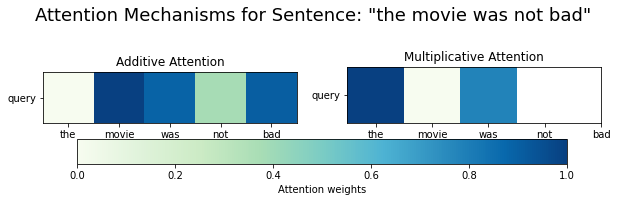

In [16]:
# Create the sentence
sentence = ['the', 'movie', 'was', 'not', 'bad']

# Plot the weights
plot_attention_weights(additive_weights, multiplicative_weights, sentence)

### Self-attention

In contrast, in self-attention, which is used in [Attention Is All You Need](http://arxiv.org/abs/1706.03762),  each input token is both a query, key, and value, and the attention weights are computed based on the similarity between all input tokens. Therefore, when visualizing self-attention, it is useful to plot the entire input sequence, along with the attention weights for each token in the sequence.

The mathematical formula for self-attention using scaled dot attention is as follows:

Given a sequence of input vectors $x_1, x_2, ..., x_n \in \mathbb{R}^d$, we compute the self-attention matrix $A \in \mathbb{R}^{n \times n}$ as follows:

$$A = softmax(\frac{XW_Q(W_K)^T}{\sqrt{d_k}})$$

where $W_Q, W_K \in \mathbb{R}^{d \times d_k}$ are learnable weight matrices and $\sqrt{d_k}$ is a scaling factor. The matrix $X \in \mathbb{R}^{n \times d}$ is obtained by multiplying the input sequence with a weight matrix $W_X \in \mathbb{R}^{d \times d}$, i.e., $X = (x_1W_X, x_2W_X, ..., x_nW_X)$.

The output of the self-attention layer is then computed as a weighted sum of the input vectors, using the attention matrix $A$:

$$y = AXW_V$$

where $W_V \in \mathbb{R}^{d \times d_v}$ is another learnable weight matrix and $y \in \mathbb{R}^{n \times d_v}$ is the output sequence. 

In [17]:
class SelfAttention(torch.nn.Module):
    """
    A self-attention module that takes an input tensor and returns a tensor with self-attention applied.

    Args:
        d_model (int): The input dimensionality.

    Attributes:
        d_model (int): The input dimensionality.
        q_linear (torch.nn.Linear): A linear layer applied to the query.
        k_linear (torch.nn.Linear): A linear layer applied to the key.
        v_linear (torch.nn.Linear): A linear layer applied to the value.

    Methods:
        forward(x): Forward pass of the self-attention module.

    Returns:
        torch.Tensor: The output tensor of the self-attention module.
        torch.Tensor: The attention weights.

    """
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)
    
    def forward(self, x):
        q = self.q_linear(x)
        k = self.k_linear(x)
        v = self.v_linear(x)
        attn_weights = F.softmax(torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_model)), dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        return attn_output, attn_weights


class SelfAttentionModel(torch.nn.Module):
    """
    A self-attention model that applies self-attention to the input tensor and returns a tensor of output size.

    Args:
        d_model (int): The input dimensionality.
        output_size (int): The output dimensionality.

    Attributes:
        self_attn (SelfAttention): A self-attention module applied to the input.
        fc (torch.nn.Linear): A linear layer applied to the output of the self-attention module.

    Methods:
        forward(x): Forward pass of the self-attention model.

    Returns:
        torch.Tensor: The output tensor of the self-attention model.
        torch.Tensor: The attention weights.

    """
    def __init__(self, d_model, output_size):
        super(SelfAttentionModel, self).__init__()
        self.self_attn = SelfAttention(d_model)
        self.fc = torch.nn.Linear(d_model, output_size)
    
    def forward(self, x):
        x, attn_weights = self.self_attn(x)
        x = self.fc(x.mean(dim=1))
        return x, attn_weights




In [18]:
def plot_attention_weights(attn_weights, tokens):
    """
    Plots the attention weights of a self-attention model given a list of tokens.

    Args:
        attn_weights (torch.Tensor): A tensor of shape (batch_size, num_heads, seq_length, seq_length)
            representing the attention weights of a self-attention model.
        tokens (List[str]): A list of strings representing the tokens in the input sequence.

    Returns:
        None. This function does not return any value. It displays a plot of the attention weights.

    Example:    tokens = ['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
                attn_weights = torch.randn(1, 8, len(tokens), len(tokens))
                plot_attention_weights(attn_weights, tokens)

    """
    fig, ax = plt.subplots()
    im = ax.imshow(attn_weights.squeeze(0).detach().numpy(), cmap='GnBu')

    # Set ticks and labels
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)

    # Rotate tick labels and set label for color bar
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)

    # Add title and show plot
    ax.set_title("Self-Attention Weights")
    fig.tight_layout()
    plt.savefig('CH02_self_attention.png', dpi=300, bbox_inches='tight')



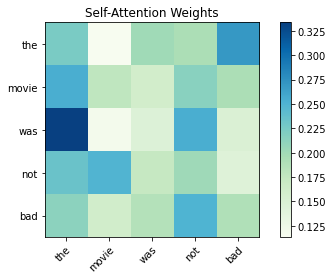

In [19]:
# initialize the sentence
sentence = "the movie was not bad"
tokens = sentence.split()

# Create word embeddings
embeddings = torch.nn.Embedding(len(tokens), 8)
inputs = embeddings(torch.tensor([i for i in range(len(tokens))]).long())


# Pass through self-attention model
model = SelfAttentionModel(d_model=8, output_size=1)
out, attn_weights = model(inputs.unsqueeze(0))

# Plot attention weights
plot_attention_weights(attn_weights, tokens)


## Computational graph comparison

Here we define two classes for a simple LSTM model and a simple Transformer model, we then create an example input tensor. The computational graph for each model is then visualized using the make_dot function from the PyTorch library, which allows us to compare the computational graphs of the two models. This comparison can help us to better understand the differences between LSTM and Transformer architectures in terms of how they process input data.

In [20]:
# Define a simple LSTM model
class LSTMModel(nn.Module):
    """
    Simple LSTM model with one layer.

    Args:
    None

    Returns:
    None

    """
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1)

    def forward(self, x):
        """
        Forward pass of the LSTM model.

        Args:
        x (torch.Tensor): Input tensor of shape (seq_len, batch_size, input_size).

        Returns:
        torch.Tensor: Output tensor of the LSTM model.

        """
        out, _ = self.lstm(x)
        return out

# Define a simple Transformer model
class TransformerModel(nn.Module):
    """
    Simple Transformer model with one encoder and decoder layer.

    Args:
    None

    Returns:
    None

    """
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=1, nhead=1, num_encoder_layers=1, num_decoder_layers=1)

    def forward(self, x):
        """
        Forward pass of the Transformer model.

        Args:
        x (torch.Tensor): Input tensor of shape (seq_len, batch_size, input_size).

        Returns:
        torch.Tensor: Output tensor of the Transformer model.

        """
        out = self.transformer(x, x)
        return out


In [21]:
# Create an example input tensor
x = torch.randn(10, 1, 1)

# Create a simple LSTM model and visualize the computational graph
lstm_model = LSTMModel()
out = lstm_model(x)
make_dot(out, params=dict(lstm_model.named_parameters())).render("lstm", format="pdf")

# Create a simple Transformer model and visualize the computational graph
transformer_model = TransformerModel()
out = transformer_model(x)
make_dot(out, params=dict(transformer_model.named_parameters())).render("transformer", format="pdf")


'transformer.pdf'